In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import zscore

from sklearn.feature_selection import chi2, SelectKBest
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('./data/raw/flights.csv')

df = df.drop(columns=['Unnamed: 9'])
df = df.dropna()
for column in ['DEP_DELAY', 'DISTANCE']:
    df = df[np.abs(zscore(df[column], axis=0)) < 3]
    
df.describe()

,DAY_OF_MONTH,DAY_OF_WEEK,DEP_TIME,DEP_DELAY,CANCELLED,DIVERTED,DISTANCE
count,456394.000000,456394.000000,456394.000000,456394.000000,456394.000000,456394.000000,456394.000000
mean,15.332081,3.853282,1320.081747,2.122797,0.000344,0.001459,724.674393
std,8.678755,1.981667,468.442817,14.383897,0.018544,0.038172,503.504208
min,1.000000,1.000000,1.000000,-44.000000,0.000000,0.000000,31.000000
25%,8.000000,2.000000,926.000000,-5.000000,0.000000,0.000000,340.000000
50%,15.000000,4.000000,1317.000000,-2.000000,0.000000,0.000000,597.000000
75%,23.000000,6.000000,1718.000000,3.000000,0.000000,0.000000,967.000000
max,30.000000,7.000000,2400.000000,87.000000,1.000000,1.000000,2466.000000


In [47]:
"""
df['IS_MONDAY'] = (df['DAY_OF_WEEK'] == 1).astype('int32')
df['IS_TUESDAY'] = (df['DAY_OF_WEEK'] == 2).astype('int32')
df['IS_WEDNESDAY'] = (df['DAY_OF_WEEK'] == 3).astype('int32')
df['IS_THIRSDAY'] = (df['DAY_OF_WEEK'] == 4).astype('int32')
df['IS_FRIDAY'] = (df['DAY_OF_WEEK'] == 5).astype('int32')
df['IS_SATURDAY'] = (df['DAY_OF_WEEK'] == 6).astype('int32')
df['IS_SUNDAY'] = (df['DAY_OF_WEEK'] == 7).astype('int32')

df['IS_MORNING'] = (df['DEP_TIME'].between(500, 1200)).astype('int32')
df['IS_DAY'] = (df['DEP_TIME'].between(1200, 1600)).astype('int32')
df['IS_EVENING'] = (df['DEP_TIME'].between(1600, 2200)).astype('int32')
df['IS_NIGHT'] = (df['DEP_TIME'].between(2200, 2400) | df['DEP_TIME'].between(0, 500)).astype('int32')

df = df.drop(columns=['DAY_OF_WEEK', 'DEP_TIME'])
"""

In [3]:
df = df.sample(n=100000)

In [4]:
# """
# df = df[df['DEP_DELAY'] >= 0]
# df['DEP_DELAY'] = df['DEP_DELAY'].where(df['DEP_DELAY'] > 0, 0)

df.describe()
# """

# df.to_csv('./data/flights.csv', index=False)

,DAY_OF_MONTH,DAY_OF_WEEK,DEP_TIME,DEP_DELAY,CANCELLED,DIVERTED,DISTANCE
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000
mean,15.331810,3.854310,1317.785130,2.159520,0.00038,0.001380,724.477770
std,8.676069,1.981187,468.333828,14.407872,0.01949,0.037123,503.622451
min,1.000000,1.000000,1.000000,-32.000000,0.00000,0.000000,31.000000
25%,8.000000,2.000000,924.000000,-5.000000,0.00000,0.000000,338.000000
50%,15.000000,4.000000,1315.000000,-2.000000,0.00000,0.000000,599.000000
75%,23.000000,6.000000,1715.000000,3.000000,0.00000,0.000000,967.000000
max,30.000000,7.000000,2400.000000,87.000000,1.00000,1.000000,2466.000000


In [35]:
"""
y = df['DEP_DELAY']
X = df.drop(columns=['DEP_DELAY'])

selector = SelectKBest(chi2, k='all')
selector.fit(X, y)
selector.pvalues_
"""

"\ny = df['DEP_DELAY']\nX = df.drop(columns=['DEP_DELAY'])\n\nselector = SelectKBest(chi2, k='all')\nselector.fit(X, y)\nselector.pvalues_\n"

<AxesSubplot:>

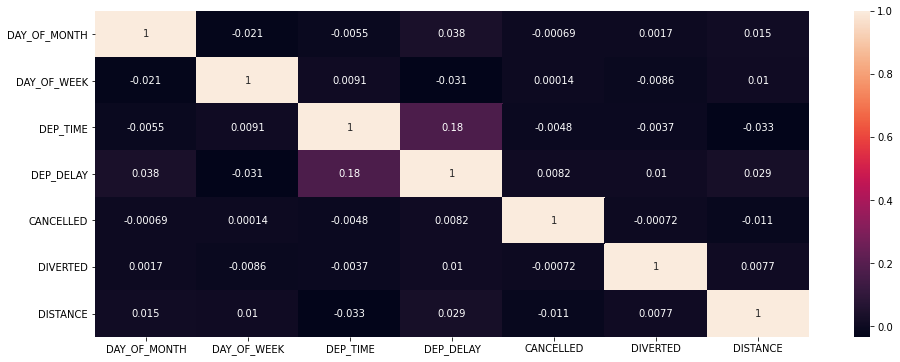

In [5]:
plt.figure(figsize=(16, 6))
sns.heatmap(df.corr(), annot=True)

In [6]:
df = df.drop(columns=['OP_UNIQUE_CARRIER', 'ORIGIN'])

# df = pd.get_dummies(df, prefix=['CARRIER'], columns = ['OP_UNIQUE_CARRIER'], drop_first=True)
# df = pd.get_dummies(df, prefix=['ORIGIN'], columns = ['ORIGIN'], drop_first=True)

# df.to_csv('./data/ff.csv')

df.describe()

,DAY_OF_MONTH,DAY_OF_WEEK,DEP_TIME,DEP_DELAY,CANCELLED,DIVERTED,DISTANCE
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000
mean,15.331810,3.854310,1317.785130,2.159520,0.00038,0.001380,724.477770
std,8.676069,1.981187,468.333828,14.407872,0.01949,0.037123,503.622451
min,1.000000,1.000000,1.000000,-32.000000,0.00000,0.000000,31.000000
25%,8.000000,2.000000,924.000000,-5.000000,0.00000,0.000000,338.000000
50%,15.000000,4.000000,1315.000000,-2.000000,0.00000,0.000000,599.000000
75%,23.000000,6.000000,1715.000000,3.000000,0.00000,0.000000,967.000000
max,30.000000,7.000000,2400.000000,87.000000,1.00000,1.000000,2466.000000


In [7]:
y = df[['DEP_DELAY']]
X = df.drop(columns=['DEP_DELAY'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)

In [8]:
scaler = MinMaxScaler()
X_train, y_train = scaler.fit_transform(X_train), scaler.fit_transform(y_train)
X_test, y_test = scaler.fit_transform(X_test), scaler.fit_transform(y_test)

In [14]:
regression = SGDRegressor(early_stopping=True, verbose=1).fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


-- Epoch 1
Norm: 0.12, NNZs: 6, Bias: 0.213748, T: 72000, Avg. loss: 0.006407
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 0.12, NNZs: 6, Bias: 0.218874, T: 144000, Avg. loss: 0.006333
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 0.11, NNZs: 6, Bias: 0.219649, T: 216000, Avg. loss: 0.006332
Total training time: 0.06 seconds.
-- Epoch 4
Norm: 0.11, NNZs: 6, Bias: 0.217776, T: 288000, Avg. loss: 0.006332
Total training time: 0.09 seconds.
-- Epoch 5
Norm: 0.11, NNZs: 6, Bias: 0.219021, T: 360000, Avg. loss: 0.006332
Total training time: 0.11 seconds.
-- Epoch 6
Norm: 0.11, NNZs: 6, Bias: 0.218218, T: 432000, Avg. loss: 0.006331
Total training time: 0.13 seconds.
-- Epoch 7
Norm: 0.11, NNZs: 6, Bias: 0.219092, T: 504000, Avg. loss: 0.006331
Total training time: 0.16 seconds.
-- Epoch 8
Norm: 0.11, NNZs: 6, Bias: 0.219113, T: 576000, Avg. loss: 0.006331
Total training time: 0.18 seconds.
-- Epoch 9
Norm: 0.11, NNZs: 6, Bias: 0.219144, T: 648000, Avg. loss: 0.006330
Total trai

In [15]:
regression.score(X_train, y_train)

0.034234436722244355

In [16]:
regression.intercept_

array([0.21914423])

In [17]:
regression.coef_

array([ 0.01299048, -0.01260773,  0.10874667,  0.00738273,  0.01181016,
        0.02163233])

In [75]:
print(regression.predict(X_test)[:5])
print(y_test[:5].T[0])

[0.33460262 0.32492287 0.3969086  0.33729359 0.34302113]
[0.27642276 0.25203252 0.32520325 0.31707317 0.2601626 ]
